In [2]:
import os

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path)

import pickle
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tdamapper.core import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.plot import MapperLayoutInteractive, MapperLayoutStatic
from tdamapper.clustering import FailSafeClustering
from sklearn import metrics

from functions import *
from chi import *
from regressionP import *
from models import *

In [2]:
data1 = pd.read_csv("./Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("./Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("./Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("./Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("./Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("./Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6], ignore_index=True)

dataA1 = pd.read_csv("./Data/NPA_TMA1_new.csv")[:-2]

In [3]:
def preprocess(input_data, select_lst):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 7]
    dataA = sample_data[select_lst]

    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

select_lst = [
    '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者',
    '道路型態大類別名稱', '事故位置大類別名稱', '事故類型及型態大類別名稱',
    '號誌-號誌種類名稱', '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '死亡受傷人數', '經度', '緯度',
]

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)

dist_df = process_data(rbind_data)
scaler = StandardScaler()

full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
X1 = full_dist.drop(['受傷', '死亡', '經度', '緯度'], axis=1).to_numpy()

full_dist.shape

(190002, 15)

In [4]:
pca = PCA(n_components=10)
lens1 = pca.fit_transform(X1)

# 查看每個主成分保留的變異量比例
explained_variance_ratio = pca.explained_variance_ratio_
sum(explained_variance_ratio)

0.8442766956454199

In [7]:
# start_time = time.time()

# lens1 = PCA(10).fit_transform(X1)

# mapper_algo1 = MapperAlgorithm(
#     cover = CubicalCover(
#         n_intervals = 4,
#         overlap_frac = 0.4
#     ),
#     clustering = FailSafeClustering(
#         clustering = AgglomerativeClustering(3, linkage='ward'),
#         verbose = False)
# )

# mapper_graph1 = mapper_algo1.fit_transform(X1, lens1)

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(elapsed_time)

In [9]:
# mapper_plot1 = MapperLayoutInteractive(
#     mapper_graph1,
#     colors = dist_df[['速限-第1當事者']].to_numpy(),
#     cmap = 'jet',
#     # agg = np.nanmean,
#     agg = most_frequent_nonan,
#     dim = 3,
#     iterations = 30,
#     seed = 6,
#     width = 800,
#     height = 500)

In [18]:
# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [21]:
# import pickle

# with open('CalculatedData/道路V2_newV2.pkl', 'wb') as f:
#     pickle.dump(mapper_graph1, f)

# 模型比較

In [10]:
# List of columns to select
select_lst = [
    '天候名稱', 
    '路面狀況-路面狀態名稱',
    '肇因研判大類別名稱-主要', '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', 
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '死亡受傷人數',
    '經度', '緯度',
    '道路型態子類別名稱', '事故位置子類別名稱', '車道劃分設施-分向設施子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別',
    
    '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱','號誌-號誌動作名稱',
]

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
rbind_data = process_age(rbind_data)
# 顏色處理
rbind_data['color'] = rbind_data['速限-第1當事者'].astype(str) + rbind_data['事故類型及型態大類別名稱']

dist_df = process_data(rbind_data)
scaler = StandardScaler()

full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
X1 = full_dist.drop(['受傷', '死亡'], axis=1).to_numpy()

# full_dist.head()

In [4]:
with open('CalculatedData/道路V2_new.pkl', 'rb') as f:
    mapper_graph1 = pickle.load(f)
    
mapper_plot1 = MapperLayoutInteractive(
    mapper_graph1,
    colors = dist_df[['color']].to_numpy(),
    cmap = 'jet',
    agg = most_frequent_nonan,
    dim = 3,
    iterations = 30,
    seed = 6,
    width = 800,
    height = 500)

In [8]:
# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [11]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    color = int(re.search(r'color: (-?\d+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [23]:
calinski_data = get_calinski_from_db(full_info, 0.025)
labels = calinski_data[3]
db = calinski_data[2]
n_clusters_ = calinski_data[4]

print(n_clusters_)

# do_plot(full_info, calinski_data, labels, db, n_clusters_)

3


In [24]:
label_0 = full_info[full_info['label'] == 0]
label_1 = full_info[full_info['label'] == 1]
label_2 = full_info[full_info['label'] == 2]
label_out = full_info[(full_info['label'] != 1) & (full_info['label'] != 2) & (full_info['label'] != 0)]

count_0 = get_count_dict(label_0)
count_1 = get_count_dict(label_1)
count_2 = get_count_dict(label_2)
count_out = get_count_dict(label_out)

full_0 = rbind_data.loc[count_0.keys()]
full_1 = rbind_data.loc[count_1.keys()]
full_2 = rbind_data.loc[count_2.keys()]
# 離群值不需要被處理
full_out = rbind_data.loc[count_out.keys()]
lst01 = list(count_0.keys() & count_1.keys())
lst02 = list(count_0.keys() & count_2.keys())
lst12 = list(count_1.keys() & count_2.keys())
lsto0 = list(count_out.keys() & count_0.keys())
lsto1 = list(count_out.keys() & count_1.keys())
lsto2 = list(count_out.keys() & count_2.keys())
# Node
full_01 = full_0.loc[lst01]
full_02 = full_0.loc[lst02]
full_12 = full_1.loc[lst12]

full_combine = pd.concat([full_01, full_02, full_12], axis=0)
full_combine = full_combine.reset_index()
full_combine = full_combine.drop_duplicates(subset='index', keep='first')
full_combine = full_combine.drop('index', axis=1)
# 去掉連接點，使分析更嚴謹
full_0 = full_0.drop(lst01 + lst02 + lsto0, errors='ignore')
full_1 = full_1.drop(lst01 + lst12 + lsto1, errors='ignore')
full_2 = full_2.drop(lst02 + lst12 + lsto2, errors='ignore')

print('01連接點數量', len(lst01))
print('02連接點數量', len(lst02))
print('12連接點數量', len(lst12))
print('o0連接點數量', len(lsto0))
print('o1連接點數量', len(lsto1))
print('o2連接點數量', len(lsto2))
print('離群值數量', full_out.shape[0])

full_combine.shape[0] + full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_out.shape[0] == rbind_data.shape[0]

01連接點數量 1499
02連接點數量 0
12連接點數量 0
o0連接點數量 85
o1連接點數量 24
o2連接點數量 162
離群值數量 391


False

In [29]:
lst_logit = [
    '路面狀況-路面狀態名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初', 
    '光線名稱', '道路類別-第1當事者-名稱',
    '速限-第1當事者', '道路型態大類別名稱', '事故位置大類別名稱', 
    '號誌-號誌種類名稱', '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱', '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種', '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱', '車輛撞擊部位大類別名稱-其他', 
    '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '路面狀況-路面鋪裝名稱', 
    # '車道劃分設施-分向設施子類別名稱', '道路障礙-障礙物名稱', '車輛撞擊部位子類別名稱-其他',

    # '號誌-號誌動作名稱', '當事者區分-類別-大類別名稱-車種', '肇因研判大類別名稱-主要', # 降低預測值
    # '道路障礙-視距名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車輛撞擊部位大類別名稱-其他', # 降低預測值
    # '道路型態子類別名稱', '路面狀況-路面缺陷名稱', '天候名稱' # 降低
]

full_combine_X, full_combine_y = get_clusterN_logit(full_combine, lst_logit)
full_0_X, full_0_y = get_clusterN_logit(full_0, lst_logit)
full_1_X, full_1_y = get_clusterN_logit(full_1, lst_logit)
full_2_X, full_2_y = get_clusterN_logit(full_2, lst_logit)
full_out_X, full_out_y = get_clusterN_logit(full_out, lst_logit)

print(full_combine_y.value_counts())
print(full_out_y.value_counts())
print(full_0_y.value_counts())
print(full_1_y.value_counts())
print(full_2_y.value_counts())

2    1478
1      21
dtype: int64
2    378
1     13
dtype: int64
2    176259
1       594
dtype: int64
2    7228
1      87
dtype: int64
2    3872
1      72
dtype: int64


# Grid Search

In [13]:
# lst_logit = [
#     '路面狀況-路面狀態名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡', 
#     '車輛撞擊部位大類別名稱-最初', 
#     '光線名稱', '道路類別-第1當事者-名稱',
#     '速限-第1當事者', '道路型態大類別名稱', '事故位置大類別名稱', 
#     '號誌-號誌種類名稱', '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
#     '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
#     '事故類型及型態大類別名稱', '事故位置子類別名稱', '事故類型及型態子類別名稱', 
#     '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
#     '當事者區分-類別-子類別名稱-車種', '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
#     '當事者行動狀態大類別名稱', '車輛撞擊部位大類別名稱-其他',
#     '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '路面狀況-路面鋪裝名稱',
#     '車道劃分設施-分向設施子類別名稱', '道路障礙-障礙物名稱', '車輛撞擊部位子類別名稱-其他',
    
# ]

# optional_features = [
#     '號誌-號誌動作名稱', '當事者區分-類別-大類別名稱-車種', #'肇因研判大類別名稱-主要', # 降低預測值
#     '道路障礙-視距名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車輛撞擊部位大類別名稱-其他', # 降低預測值
#     '道路型態子類別名稱', '路面狀況-路面缺陷名稱', '天候名稱' # 降低
# ]

# for i in range(len(optional_features)):
#     # 每次迴圈加入一個新特徵
#     current_lst_logit = lst_logit + [optional_features[i]]

#     # 重新生成資料
#     full_combine_X, full_combine_y = get_clusterN_logit(full_combine, current_lst_logit)
#     full_0_X, full_0_y = get_clusterN_logit(full_0, current_lst_logit)
#     full_1_X, full_1_y = get_clusterN_logit(full_1, current_lst_logit)
#     full_2_X, full_2_y = get_clusterN_logit(full_2, current_lst_logit)
#     full_out_X, full_out_y = get_clusterN_logit(full_out, current_lst_logit)

#     start_time = time.time()
#     matrix_0, score_0, cm_0 = logistic_cm_gridsearch(full_0_X, full_0_y)
#     matrix_1, score_1, cm_1 = logistic_cm_gridsearch(full_1_X, full_1_y)
#     matrix_2, score_2, cm_2 = logistic_cm_gridsearch(full_2_X, full_2_y)
    
#     # 輸出結果
#     print(f"特徵: {optional_features[i]}")
#     print(f"Scores: {score_0}, {score_1}, {score_2}")
    
#     end_time = time.time()
#     elapsed_time = end_time - start_time
#     print(f"Elapsed Time: {elapsed_time} seconds\n")


In [143]:
# full_out.to_csv('CalculatedData/離群比較/拓墣V2_new.csv', index=False)

In [20]:
start_time = time.time()
matrix_combine, score_combine, cm_combine = logistic_cm_gridsearch(full_combine_X, full_combine_y)
matrix_out, score_out, cm_out = logistic_cm_gridsearch(full_out_X, full_out_y)
print(score_combine, score_out)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

0.6 0.75
25.610748767852783


In [21]:
start_time = time.time()
matrix_0, score_0, cm_0 = logistic_cm_gridsearch(full_0_X, full_0_y)
matrix_1, score_1, cm_1 = logistic_cm_gridsearch(full_1_X, full_1_y)
matrix_2, score_2, cm_2 = logistic_cm_gridsearch(full_2_X, full_2_y)
print(score_0, score_1, score_2)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

0.6984126984126984 0.8 0.6521739130434783
202.27635097503662


In [22]:
print(matrix_0, '\n\n', matrix_1, '\n\n', matrix_2, '\n\n', matrix_combine, '\n\n', matrix_out)

     Label  Precision    Recall  F1 Score
0  Class_0   0.714286  0.661376  0.686813
1  Class_1   0.684729  0.735450  0.709184 

      Label  Precision  Recall  F1 Score
0  Class_0      0.875     0.7  0.777778
1  Class_1      0.750     0.9  0.818182 

      Label  Precision    Recall  F1 Score
0  Class_0   0.705882  0.521739  0.600000
1  Class_1   0.620690  0.782609  0.692308 

      Label  Precision  Recall  F1 Score
0  Class_0   1.000000     0.2  0.333333
1  Class_1   0.555556     1.0  0.714286 

      Label  Precision  Recall  F1 Score
0  Class_0       0.75    0.75      0.75
1  Class_1       0.75    0.75      0.75


In [48]:
# np.savetxt('CalculatedData/V2準確資料/cm_combine.txt', cm_combine, fmt='%d')
# np.savetxt('CalculatedData/V2準確資料/cm_out.txt', cm_out, fmt='%d')
# np.savetxt('CalculatedData/V2準確資料/cm_0.txt', cm_0, fmt='%d')
# np.savetxt('CalculatedData/V2準確資料/cm_1.txt', cm_1, fmt='%d')
# np.savetxt('CalculatedData/V2準確資料/cm_2.txt', cm_2, fmt='%d')

# np.savetxt('CalculatedData/V2準確資料/cm_origin.txt', cm_origin, fmt='%d')

In [140]:
print(cm_0 + cm_1 + cm_2 + cm_combine + cm_out)

[[155  86]
 [ 58 183]]


In [40]:
conf_matrix = cm_0 + cm_1 + cm_2 + cm_combine + cm_out

y_test, y_pred = [], []
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        y_test.extend([i] * conf_matrix[i][j])
        y_pred.extend([j] * conf_matrix[i][j])

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None, zero_division=0)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Label': [f'Class_{i}' for i in range(len(precision))],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})
metrics_df

,Label,Precision,Recall,F1 Score
0,Class_0,0.727700,0.643154,0.682819
1,Class_1,0.680297,0.759336,0.717647


### Mapper logistic總平均和評估指標

In [42]:
de = np.sum(cm_0 + cm_1 + cm_2 + cm_combine + cm_out)
logit_avg_score = (np.sum(cm_0)/de)*score_0 + (np.sum(cm_1)/de)*score_1 + (np.sum(cm_2)/de)*score_2 + (np.sum(cm_combine)/de)*score_combine + (np.sum(cm_out)/de)*score_out
print(logit_avg_score)

0.7012448132780081


### 原始logistic方法總平均和評估指標

In [23]:
origin_X, origin_y = get_clusterN_logit(rbind_data, lst_logit)

start_time = time.time()

matrix_origin, score_origin, cm_origin = logistic_cm_gridsearch(origin_X, origin_y)
print(score_origin)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

0.686046511627907
212.16156220436096


In [24]:
print(matrix_origin, '\n\n', cm_origin)

     Label  Precision    Recall  F1 Score
0  Class_0   0.685185  0.688372  0.686775
1  Class_1   0.686916  0.683721  0.685315 

 [[148  67]
 [ 68 147]]


In [72]:
print('TDA')
print(cm_0 + cm_1 + cm_2 + cm_combine + cm_out)
print(metrics_df)
print('Origin')
print(cm_origin)
print(matrix_origin)

TDA
[[155  86]
 [ 58 183]]
     Label  Precision    Recall  F1 Score
0  Class_0   0.727700  0.643154  0.682819
1  Class_1   0.680297  0.759336  0.717647
Origin
[[148  67]
 [ 68 147]]
     Label  Precision    Recall  F1 Score
0  Class_0   0.685185  0.688372  0.686775
1  Class_1   0.686916  0.683721  0.685315


# SVM

In [29]:
start_time = time.time()

matrix_combine_svm, score_combine_svm, cm_combine_svm = svc_cm_with_grid_search(full_combine_X,  full_combine_y)
matrix_out_svm, score_out_svm, cm_out_svm = svc_cm_with_grid_search(full_out_X,  full_out_y)
print(score_combine_svm, score_out_svm)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



0.5 0.75
7.847566843032837


In [43]:
cm_combine_svm

array([[1, 4],
       [1, 4]])

In [44]:
cm_out_svm

array([[3, 1],
       [1, 3]])

In [32]:
start_time = time.time()

matrix_0_svm, score_0_svm, cm_0_svm = svc_cm_with_grid_search(full_0_X, full_0_y)
print('0')
matrix_1_svm, score_1_svm, cm_1_svm = svc_cm_with_grid_search(full_1_X, full_1_y)
print('1')
matrix_2_svm, score_2_svm, cm_2_svm = svc_cm_with_grid_search(full_2_X, full_2_y)
print('2')

print(score_0_svm, score_1_svm, score_2_svm)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to co

0


/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



1
2
0.6825396825396826 0.85 0.6304347826086957
3671.2984499931335


/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [33]:
print(cm_0_svm, '\n', cm_1_svm, '\n', cm_2_svm)

[[123  66]
 [ 54 135]] 
 [[16  4]
 [ 2 18]] 
 [[14  9]
 [ 8 15]]


In [34]:
print(cm_0_svm + cm_1_svm + cm_2_svm)

[[153  79]
 [ 64 168]]


### Mapper svm總平均和評估指標

In [45]:
print(matrix_0_svm, '\n\n', matrix_1_svm, '\n\n', matrix_2_svm)

     Label  Precision    Recall  F1 Score
0  Class_0   0.694915  0.650794  0.672131
1  Class_1   0.671642  0.714286  0.692308 

      Label  Precision  Recall  F1 Score
0  Class_0   0.888889     0.8  0.842105
1  Class_1   0.818182     0.9  0.857143 

      Label  Precision    Recall  F1 Score
0  Class_0   0.636364  0.608696  0.622222
1  Class_1   0.625000  0.652174  0.638298


In [36]:
de = np.sum(cm_0_svm + cm_1_svm + cm_2_svm + cm_combine_svm + cm_out_svm)
logit_avg_score = (np.sum(cm_0_svm)/de)*score_0_svm + (np.sum(cm_1_svm)/de)*score_1_svm + (np.sum(cm_2_svm)/de)*score_2_svm + (np.sum(cm_combine_svm)/de)*score_combine_svm + (np.sum(cm_out_svm)/de)*score_out_svm
print(logit_avg_score)

0.6887966804979252


In [73]:
origin_X, origin_y = get_clusterN_logit(rbind_data, lst_logit)

start_time = time.time()

matrix_origin_svm, score_origin_svm, cm_origin_svm = svc_cm_with_grid_search(origin_X, origin_y)
print(score_origin_svm)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



0.6883720930232559
4749.776369094849


/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



### 原始svm方法總平均和評估指標

In [74]:
matrix_origin_svm

,Label,Precision,Recall,F1 Score
0,Class_0,0.681614,0.706977,0.694064
1,Class_1,0.695652,0.669767,0.682464


In [75]:
score_origin_svm

0.6883720930232559

In [76]:
cm_origin_svm

array([[152,  63],
       [ 71, 144]])

In [77]:
np.savetxt('CalculatedData/V2準確資料/cm_combine_svm.txt', cm_combine_svm, fmt='%d')
np.savetxt('CalculatedData/V2準確資料/cm_out_svm.txt', cm_out_svm, fmt='%d')
np.savetxt('CalculatedData/V2準確資料/cm_0_svm.txt', cm_0_svm, fmt='%d')
np.savetxt('CalculatedData/V2準確資料/cm_1_svm.txt', cm_1_svm, fmt='%d')
np.savetxt('CalculatedData/V2準確資料/cm_2_svm.txt', cm_2_svm, fmt='%d')

np.savetxt('CalculatedData/V2準確資料/cm_origin_svm.txt', cm_origin_svm, fmt='%d')

In [78]:
matrix_origin_svm

,Label,Precision,Recall,F1 Score
0,Class_0,0.681614,0.706977,0.694064
1,Class_1,0.695652,0.669767,0.682464


# Get all data

In [24]:
cm_combine = np.loadtxt('CalculatedData/V2準確資料/cm_combine.txt', dtype=int)
cm_out = np.loadtxt('CalculatedData/V2準確資料/cm_out.txt', dtype=int)
cm_0 = np.loadtxt('CalculatedData/V2準確資料/cm_0.txt', dtype=int)
cm_1 = np.loadtxt('CalculatedData/V2準確資料/cm_1.txt', dtype=int)
cm_2 = np.loadtxt('CalculatedData/V2準確資料/cm_2.txt', dtype=int)
cm_origin = np.loadtxt('CalculatedData/V2準確資料/cm_origin.txt', dtype=int)

cm_combine_svm = np.loadtxt('CalculatedData/V2準確資料/cm_combine_svm.txt', dtype=int)
cm_out_svm = np.loadtxt('CalculatedData/V2準確資料/cm_out_svm.txt', dtype=int)
cm_0_svm = np.loadtxt('CalculatedData/V2準確資料/cm_0_svm.txt', dtype=int)
cm_1_svm = np.loadtxt('CalculatedData/V2準確資料/cm_1_svm.txt', dtype=int)
cm_2_svm = np.loadtxt('CalculatedData/V2準確資料/cm_2_svm.txt', dtype=int)
cm_origin_svm = np.loadtxt('CalculatedData/V2準確資料/cm_origin_svm.txt', dtype=int)

In [25]:
def get_matrix(conf_matrix):  
    y_test, y_pred = [], []
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix[i])):
            y_test.extend([i] * conf_matrix[i][j])
            y_pred.extend([j] * conf_matrix[i][j])

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None, zero_division=0)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)

    metrics_df = pd.DataFrame({
        'Label': [f'Class_{i}' for i in range(len(precision))],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    return metrics_df

# Classification full inform

In [26]:
print(get_matrix(cm_out))
print(get_matrix(cm_combine))
print(get_matrix(cm_0))
print(get_matrix(cm_1))
print(get_matrix(cm_2))

     Label  Precision  Recall  F1 Score
0  Class_0       0.75    0.75      0.75
1  Class_1       0.75    0.75      0.75
     Label  Precision  Recall  F1 Score
0  Class_0   1.000000     0.2  0.333333
1  Class_1   0.555556     1.0  0.714286
     Label  Precision    Recall  F1 Score
0  Class_0   0.714286  0.661376  0.686813
1  Class_1   0.684729  0.735450  0.709184
     Label  Precision  Recall  F1 Score
0  Class_0      0.875     0.7  0.777778
1  Class_1      0.750     0.9  0.818182
     Label  Precision    Recall  F1 Score
0  Class_0   0.705882  0.521739  0.600000
1  Class_1   0.620690  0.782609  0.692308


In [27]:
print(get_matrix(cm_out_svm))
print(get_matrix(cm_combine_svm))
print(get_matrix(cm_0_svm))
print(get_matrix(cm_1_svm))
print(get_matrix(cm_2_svm))

     Label  Precision  Recall  F1 Score
0  Class_0       0.75    0.75      0.75
1  Class_1       0.75    0.75      0.75
     Label  Precision  Recall  F1 Score
0  Class_0        0.5     0.2  0.285714
1  Class_1        0.5     0.8  0.615385
     Label  Precision    Recall  F1 Score
0  Class_0   0.694915  0.650794  0.672131
1  Class_1   0.671642  0.714286  0.692308
     Label  Precision  Recall  F1 Score
0  Class_0   0.888889     0.8  0.842105
1  Class_1   0.818182     0.9  0.857143
     Label  Precision    Recall  F1 Score
0  Class_0   0.636364  0.608696  0.622222
1  Class_1   0.625000  0.652174  0.638298


In [28]:
print(get_matrix(cm_out + cm_combine + cm_0 + cm_1 + cm_2))
print(get_matrix(cm_out_svm + cm_combine_svm + cm_0_svm + cm_1_svm + cm_2_svm))
print(get_matrix(cm_origin))
print(get_matrix(cm_origin_svm))

     Label  Precision    Recall  F1 Score
0  Class_0   0.727700  0.643154  0.682819
1  Class_1   0.680297  0.759336  0.717647
     Label  Precision    Recall  F1 Score
0  Class_0   0.704036  0.651452  0.676724
1  Class_1   0.675676  0.726141  0.700000
     Label  Precision    Recall  F1 Score
0  Class_0   0.685185  0.688372  0.686775
1  Class_1   0.686916  0.683721  0.685315
     Label  Precision    Recall  F1 Score
0  Class_0   0.681614  0.706977  0.694064
1  Class_1   0.695652  0.669767  0.682464


In [29]:
print(cm_origin)
print(cm_origin_svm)

[[148  67]
 [ 68 147]]
[[152  63]
 [ 71 144]]


In [30]:
mapper_logistic = cm_combine + cm_out + cm_0 + cm_1 + cm_2
mapper_svm = cm_combine_svm + cm_out_svm + cm_0_svm + cm_1_svm + cm_2_svm

print(mapper_logistic)
print(mapper_svm)

[[155  86]
 [ 58 183]]
[[157  84]
 [ 66 175]]


In [31]:
TP = mapper_logistic[0, 0]
FP = mapper_logistic[0, 1]
FN = mapper_logistic[1, 0]
TN = mapper_logistic[1, 1]

# Manually constructing the predicted and actual values based on the confusion matrix
y_true = [0] * (TP + FP) + [1] * (FN + TN)
y_pred = [0] * TP + [1] * FP + [0] * FN + [1] * TN

# Calculating the precision, recall, f1 score and accuracy using scikit-learn
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Label': [f'Class_{i}' for i in range(len(precision))],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

metrics_df

,Label,Precision,Recall,F1 Score
0,Class_0,0.727700,0.643154,0.682819
1,Class_1,0.680297,0.759336,0.717647


In [32]:
def get_acc(cm):
    accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
    return accuracy

score_origin = get_acc(cm_origin)
score_origin_svm = get_acc(cm_origin_svm)

In [33]:
de = np.sum(cm_0 + cm_1 + cm_2 + cm_combine + cm_out)
logit_avg_score = (np.sum(cm_0)/de)*get_acc(cm_0) + (np.sum(cm_1)/de)*get_acc(cm_1) + (np.sum(cm_2)/de)*get_acc(cm_2) + (np.sum(cm_combine)/de)*get_acc(cm_combine) + (np.sum(cm_out)/de)*get_acc(cm_out)
print(logit_avg_score)

de = np.sum(cm_0_svm + cm_1_svm + cm_2_svm + cm_combine_svm + cm_out_svm)
svm_avg_score = (np.sum(cm_0_svm)/de)*get_acc(cm_0_svm) + (np.sum(cm_1_svm)/de)*get_acc(cm_1_svm) + (np.sum(cm_2_svm)/de)*get_acc(cm_2_svm) + (np.sum(cm_combine_svm)/de)*get_acc(cm_combine_svm) + (np.sum(cm_out_svm)/de)*get_acc(cm_out_svm)
print(svm_avg_score)

0.7012448132780081
0.6887966804979252


In [34]:
print(get_matrix(cm_out + cm_combine + cm_0 + cm_1 + cm_2))
print(get_matrix(cm_out_svm + cm_combine_svm + cm_0_svm + cm_1_svm + cm_2_svm))
print(get_matrix(cm_origin))
print(get_matrix(cm_origin_svm))

     Label  Precision    Recall  F1 Score
0  Class_0   0.727700  0.643154  0.682819
1  Class_1   0.680297  0.759336  0.717647
     Label  Precision    Recall  F1 Score
0  Class_0   0.704036  0.651452  0.676724
1  Class_1   0.675676  0.726141  0.700000
     Label  Precision    Recall  F1 Score
0  Class_0   0.685185  0.688372  0.686775
1  Class_1   0.686916  0.683721  0.685315
     Label  Precision    Recall  F1 Score
0  Class_0   0.681614  0.706977  0.694064
1  Class_1   0.695652  0.669767  0.682464


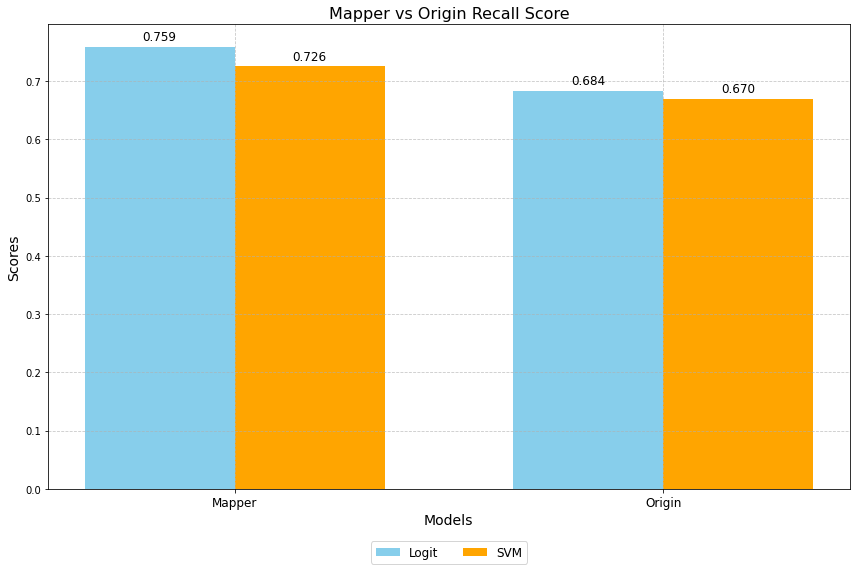

In [107]:
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['DejaVu Sans']

categories = ['Mapper', 'Origin']
logit_scores = [0.759336, 0.683721]
svm_scores = [0.726141, 0.669767]

x = np.arange(len(categories))
width = 0.35  

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, logit_scores, width, label='Logit', color='skyblue')
rects3 = ax.bar(x + width/2, svm_scores, width, label='SVM', color='orange')

ax.grid(True, linestyle='--', alpha=0.7)

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Mapper vs Origin Recall Score', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=12)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12)

autolabel(rects1)
autolabel(rects3)

fig.tight_layout()

plt.show()

fig.savefig('CalculatedData/道路分析V2_recall.png', bbox_inches='tight')

In [106]:
print(logit_avg_score)
print(svm_avg_score)
print(score_origin)
print(score_origin_svm)

0.7012448132780081
0.6887966804979252
0.686046511627907
0.6883720930232559


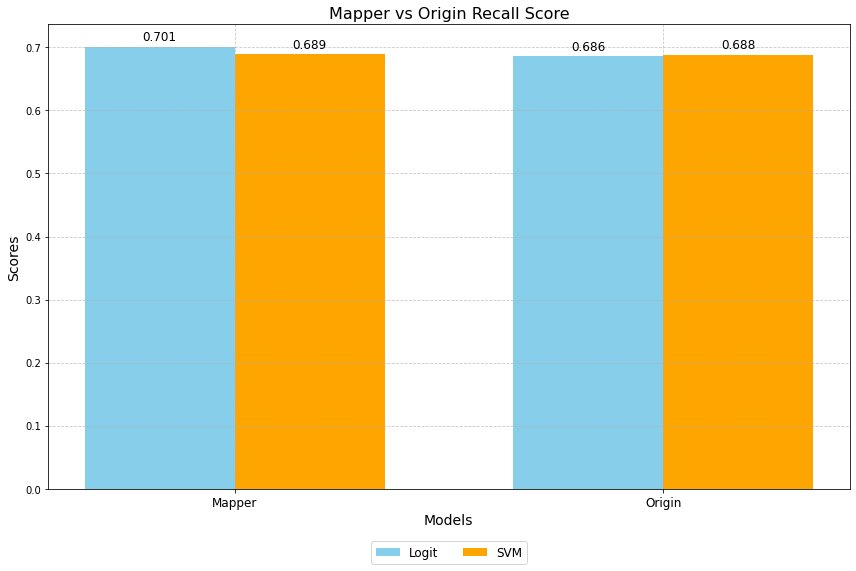

In [101]:
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['DejaVu Sans']

categories = ['Mapper', 'Origin']
logit_scores = [logit_avg_score, score_origin]
svm_scores = [svm_avg_score, score_origin_svm]

x = np.arange(len(categories))
width = 0.35  

fig, ax = plt.subplots(figsize=(12, 8))  # 设置图像大小
rects1 = ax.bar(x - width/2, logit_scores, width, label='Logit', color='skyblue')
rects3 = ax.bar(x + width/2, svm_scores, width, label='SVM', color='orange')

# 添加网格线
ax.grid(True, linestyle='--', alpha=0.7)

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Mapper vs Origin Recall Score', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=12)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12)

autolabel(rects1)
autolabel(rects3)

fig.tight_layout()

plt.show()

fig.savefig('CalculatedData/道路分析.png', bbox_inches='tight')

# 顯著特徵

In [32]:
lst_regression = [
    '光線名稱',
    '道路類別-第1當事者-名稱', 
    '速限-第1當事者', 
    '道路型態大類別名稱', '事故位置大類別名稱',
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
]

X01, y01, p01 = pval(full_0, full_1, lst_regression)

p01[p01['p_value'] < 0.05]

,coefficients,standard_error,wald_statistics,p_value,feature
光線名稱,5.028305,0.467947,10.745464,0.000000,光線名稱
事故位置大類別名稱,-0.978137,0.418579,-2.336806,0.019449,事故位置大類別名稱
道路型態大類別名稱,0.923925,0.441264,2.093816,0.036276,道路型態大類別名稱


In [10]:
def table(colnames, full_0, full_1, full_12):
    
    combined_df = pd.concat([full_0[colnames].value_counts(normalize = True), 
                             full_1[colnames].value_counts(normalize = True),
                             full_12[colnames].value_counts(normalize = True)
                            ],
                            axis=1).fillna(0)

    combined_df.columns = ['車與車、低速線', '人與車、低速限', '車與車、高速限']
    
    return combined_df

In [16]:
# table_lst = [
#     '路面狀況-路面狀態名稱',
#     '當事者屬-性-別名稱', 
#     '當事者事故發生時年齡', 
#     '車輛撞擊部位大類別名稱-最初',
#     '光線名稱',
#     '道路類別-第1當事者-名稱',
#     '道路型態大類別名稱',
#     '事故位置大類別名稱',
#     '號誌-號誌種類名稱',
#     '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
#     '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
#     '事故類型及型態大類別名稱',
#     '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
#     '當事者行動狀態大類別名稱',
#     '車輛撞擊部位大類別名稱-其他', 
#     '肇因研判大類別名稱-個別', 
#     '肇事逃逸類別名稱-是否肇逃',
#     '路面狀況-路面鋪裝名稱', 
#     '道路障礙-障礙物名稱',
#     '死亡'
# ]
table_lst = [
    '路面狀況-路面鋪裝名稱',
    '路面狀況-路面狀態名稱',
    '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱',
    '道路障礙-視距品質名稱',
    '道路障礙-視距名稱',
]
for i in table_lst:
    result = table(i, full_0, full_1, full_2)
    print(i,'\n',result)

路面狀況-路面鋪裝名稱 
       cluster1  cluster2  cluster12
柏油    0.990546  0.979631   0.995943
水泥    0.003902  0.006425   0.003296
其他鋪裝  0.002889  0.011620   0.000507
無鋪裝   0.002403  0.001914   0.000254
碎石    0.000260  0.000410   0.000000
路面狀況-路面狀態名稱 
     cluster1  cluster2  cluster12
乾燥  0.890932  0.830075   0.872465
濕潤  0.106569  0.168694   0.126521
泥濘  0.001142  0.000410   0.000254
油滑  0.001035  0.000410   0.000254
冰雪  0.000322  0.000410   0.000507
路面狀況-路面缺陷名稱 
           cluster1  cluster2  cluster12
無缺陷       0.995160  0.997403   0.999239
突出(高低)不平  0.002629  0.000957   0.000507
有坑洞       0.001498  0.000820   0.000254
路面鬆軟      0.000712  0.000820   0.000000
道路障礙-障礙物名稱 
           cluster1  cluster2  cluster12
無障礙物      0.983506  0.977444   0.974391
路上有停車     0.006293  0.010526   0.003043
其他障礙物     0.004880  0.004238   0.011156
道路工事(程)中  0.004744  0.005332   0.011156
攤位、棚架     0.000390  0.002051   0.000000
有堆積物      0.000187  0.000410   0.000254
道路障礙-視距品質名稱 
       cluster1  cluster2  clust

In [116]:
# chi_compare(full_0, full_1)

In [36]:
# chi_compare(full_0, full_2)

In [37]:
# chi_compare(full_1, full_2)